## **Analysis & Prediction of Telecom Customer Churn**




## 1. Importing  Library

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier ,RandomForestClassifier ,GradientBoostingClassifier
from xgboost import XGBClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score ,mean_squared_error,accuracy_score,classification_report,roc_curve,confusion_matrix
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

---

## 2. Loading Data

In [3]:
df = pd.read_csv('data.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


    target column is 'Churn'

---

## 3. Preliminary Data Exploration & Preparation

#### Dropping unnecesary column(s)

In [4]:
#dropping 'customerID' coulmn because it serves no puro=pose in training
#and also dropping 'StreamingTV' column becuase data has already a column called 'StreamingMovies'
df.drop(['customerID', 'StreamingTV'],axis=1,inplace=True)

#### Checking data type of columns

In [5]:
#checking data type of columns of dataframe 'df' using dtypes
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

    Categorical type- object
    Numerical type- int64, float64

#### Checking missing values in data

In [6]:
#columnwise number of missing values 
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

    No missing values in this data

#### Checking if data is balanced or imbalanced

In [7]:
def imbalance(target_column):
    return (target_column.value_counts()/target_column.value_counts().sum())*100

imbalance(df['Churn'])

No     73.463013
Yes    26.536987
Name: Churn, dtype: float64

Data is quite imbalanced in which 'No' are dominating.

NOTE: It is expected to have majority of customers not churning, otherwise it would be an example of failed business model and nothing can be done to save it.

#### Detecting outliers

In [8]:
def detect_outliers(dataframe):
    cols = list(dataframe)
    outliers = pd.DataFrame(columns=['Feature','No. of Outliers'])
    
    for column in cols:
        if column in dataframe.select_dtypes(include=np.number).columns:
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            fence_low = q1 - (1.5*iqr)
            fence_high = q3 + (1.5*iqr)
            outliers = outliers.append({'Feature':column,'No. of Outliers':dataframe.loc[(dataframe[column] < fence_low) | (dataframe[column] > fence_high)].shape[0]},ignore_index=True)
    return outliers

detect_outliers(df)

,Feature,No. of Outliers
0,SeniorCitizen,1142
1,tenure,0
2,MonthlyCharges,0


    Only 'SeniorCitizen' has outliers. We'll see this visually in EDA section and there we will try to treat these outliers

---

## 4. Exploratory Data Analysis

#### Univariate analysis of categorical columns

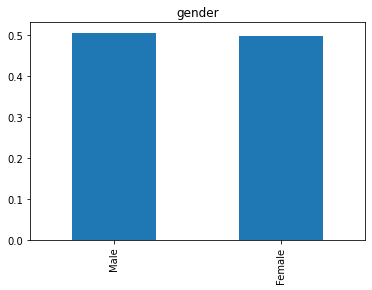

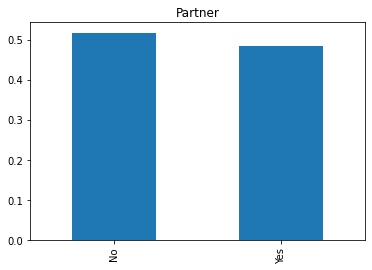

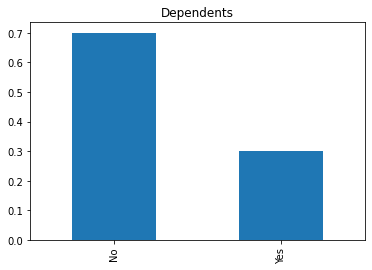

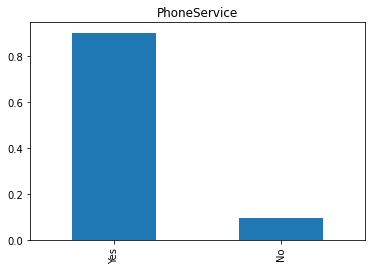

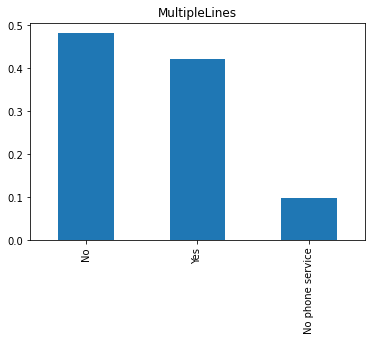

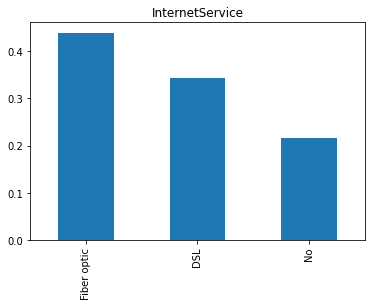

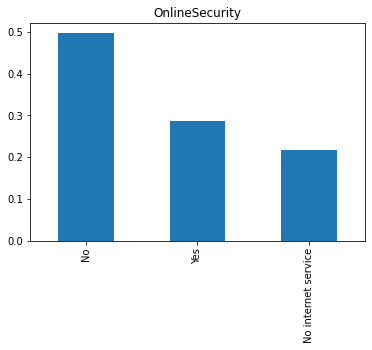

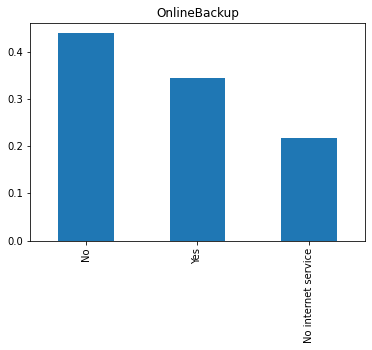

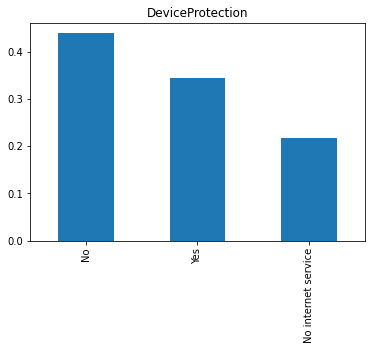

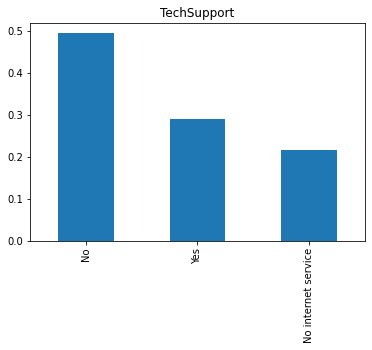

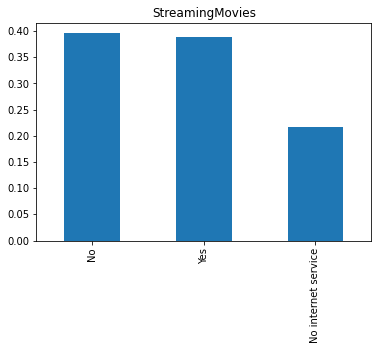

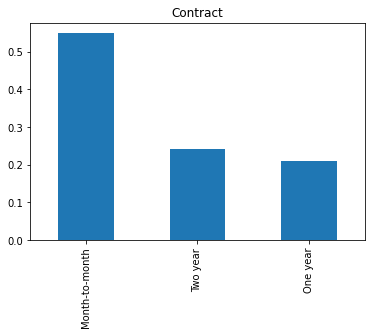

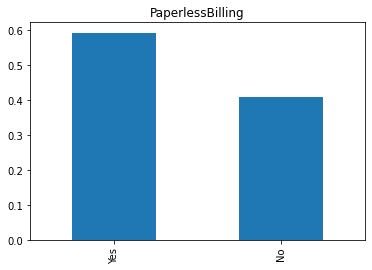

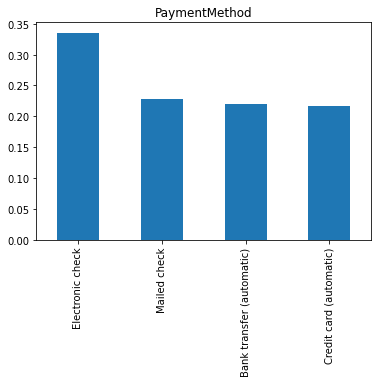

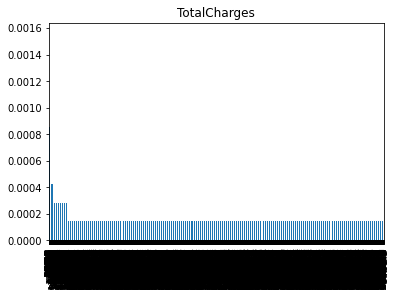

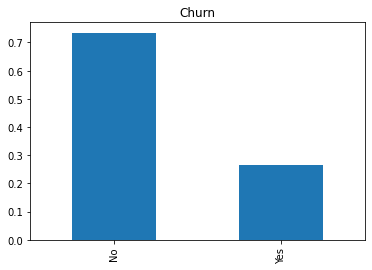

In [9]:
#plotting bar plot of categorical columns
def univariate_categorical(df):
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    for i in categorical_columns:
        df[i].value_counts(normalize=True).plot(kind='bar')
        plt.title(i)
        plt.show()   
        
univariate_categorical(df)

**Observations:**



      * Data is divided equally amongst gender.
      * Same is the case with partners
      * Majority have no dependent
      * Most of the people havve phone connections but not multiple connection
      * Fiber Optic is the most opted internet connection method
      * Not many people prefered online security, online backup, device protection & tech support
      * If we ignore the people without internet connection at all then users users are divided almost equally to streaming movies and not streaming it.
      * Majority of users have monthy contract
      * More number of people prefer paperless billing over conventional paper billing.
      * Electronic check is the widely used payment method where as rest of the methods are equally divided.
      * Lastly, as pointed out in finding imbalance in data, it was clear that data is inclined towards non-churners

      note: You are seeing Total Charges in above plot. This is because the way this data is collected/manipulated before publishing has made this particular column categorical instead numerical, which it should be.



#### Univariate analysis of continuous columns

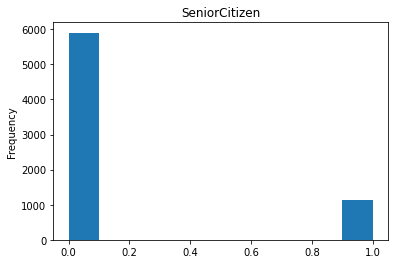

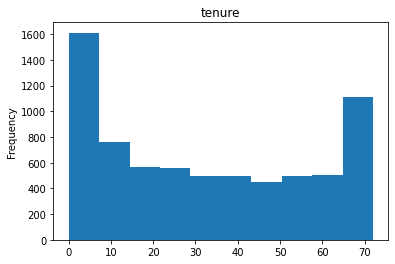

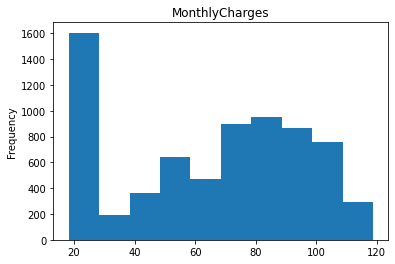

In [10]:
#plotting histogram of continuous columns
def univariate_continuous_hist(df):
    continuous_columns = df.select_dtypes(include=['number']).columns
    
    for i in continuous_columns:
        df[i].plot(kind='hist')        
        plt.title(i)
        plt.show()   
        
univariate_continuous_hist(df)

**Observations:**

    * Majority of the customers are not senior citizen
    * Most number of customers have tenure of <10 months
    * There is a significant number of people having less monthly charges (20-30)

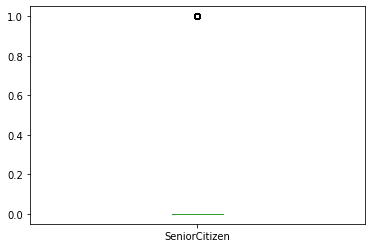

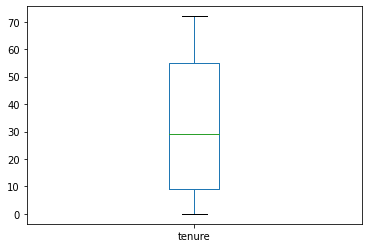

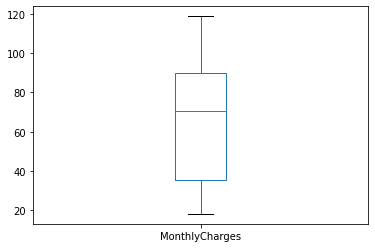

In [11]:
#plotting boxplot of continuous columns
def univariate_continuous_box(df):
    continuous_columns = df.select_dtypes(include=['number']).columns
    
    for i in continuous_columns:
        df[i].plot(kind='box')        
        plt.show()   
        
univariate_continuous_box(df)

As told earlier, senior citizen colummn has outliers, which is now also visually proven. Tha t what we are going to treat in the next cell.

In [12]:
#treating outliers 
def treat_outliers(df):
    cols = list(df)
    for col in cols:
        if col in df.select_dtypes(include=np.number).columns:
            df[col] = winsorize(df[col], limits=[0.05, 0.1],inclusive=(True, True))
    
    return df    


df = treat_outliers(df)

#### Bivariate analysis of categorical columns

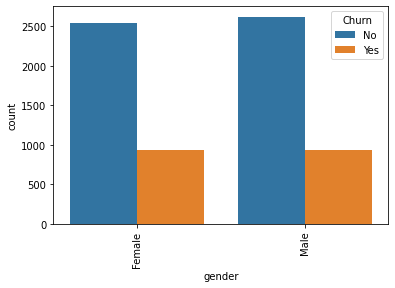

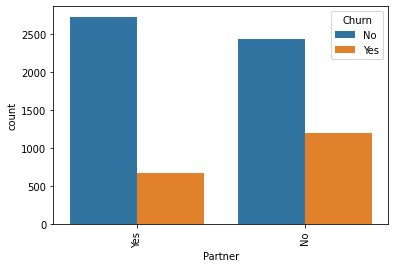

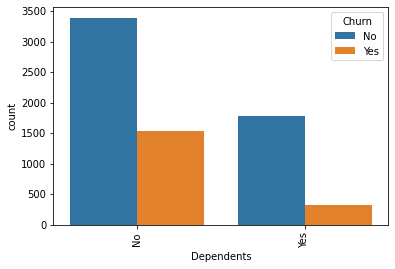

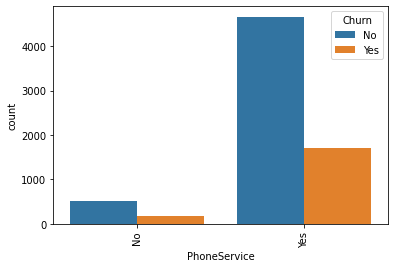

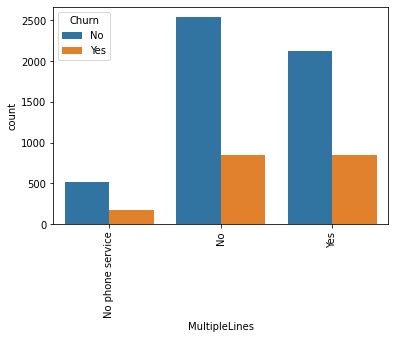

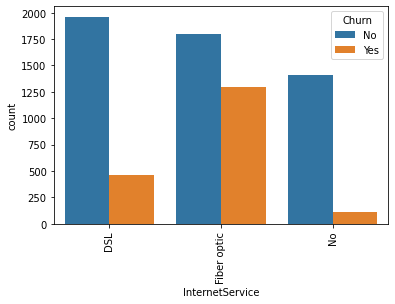

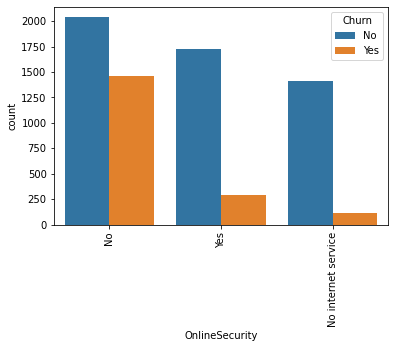

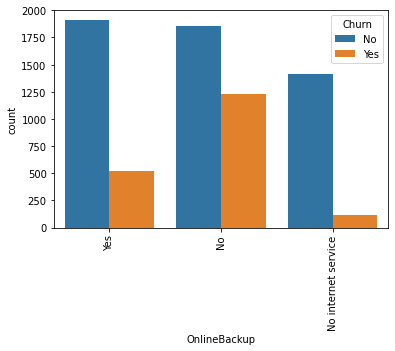

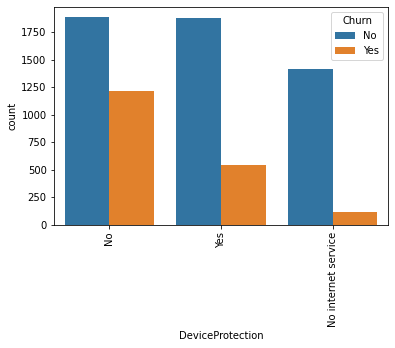

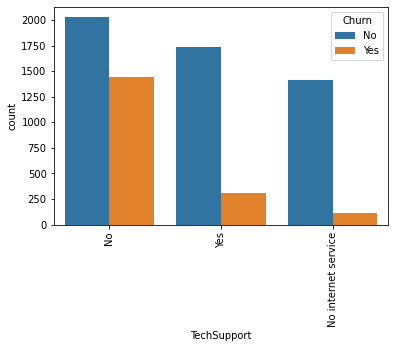

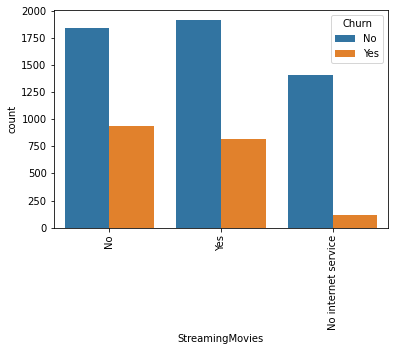

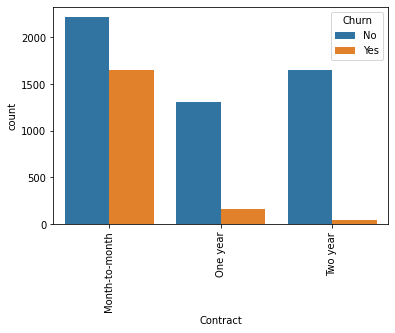

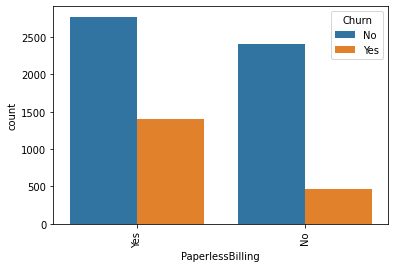

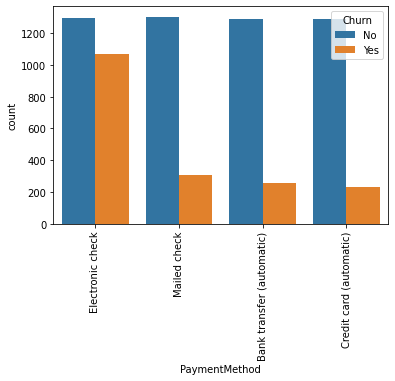

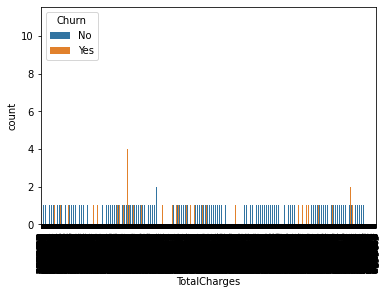

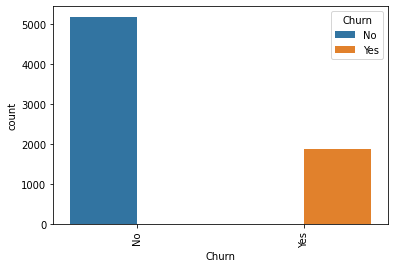

In [13]:
#plotting bar pot of categorical columns for bivariate analysis
def bivariate_categorical(df, target):
    categorical_columns = df.select_dtypes(include=['object']).columns
    
    for i in categorical_columns:
        sns.countplot(df[i],hue=target,data=df)
        plt.xticks(rotation=90)
        plt.show() 
    
        
bivariate_categorical(df, df['Churn'])

**Observations:**

    * Churning rate is divided equally amongst the genders.
    * People without any partner churned out more.
    * Same is the case with dependets.
    * Customer with phone service churned out more as compared to no having it.
    * Most of the customers that did not churned out are not having mutiple lines.
    * Customers with fiber optic as internet service churnede out more as compared to any other types.
    * In case of services such as online security, online backup, device protection & tech support, customers with these services turned on are churned lesser as compared to those who didn't opted it.
    * Customers are divided fairly in streaming movies.
    * Monthly contract customers are more likely to churn as compared to longer commitments. Obviously.


#### Converting categorical columns to numerical columns

In [14]:
#converting categorical to numerical using label encoder
for i in df.columns:
    if df[i].dtype != np.number:
        df[i] = LabelEncoder().fit_transform(df[i])

---

## 5. Machine Learning Modelling

#### a. Splitting data into dependent and independent variables

In [15]:
#Dividing data into dependent & independent variable(s)
X = df.drop('Churn', axis= 1) 
y = df['Churn']

#### b. Fitting Vanilla models

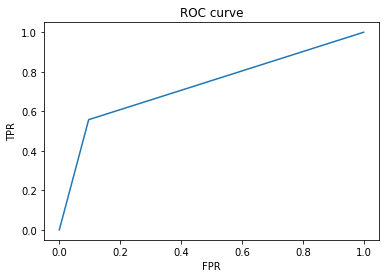

AUC Score = 73.06 %
Model: Logistic Regression
------------------------------------------------------------



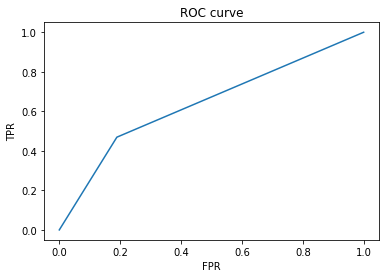

AUC Score = 64.00 %
Model: Decision Tree
------------------------------------------------------------



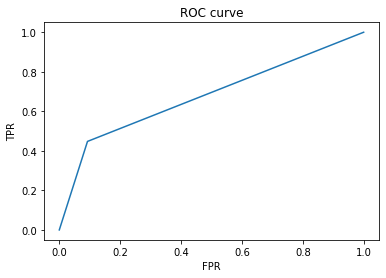

AUC Score = 67.75 %
Model: Random Forest
------------------------------------------------------------



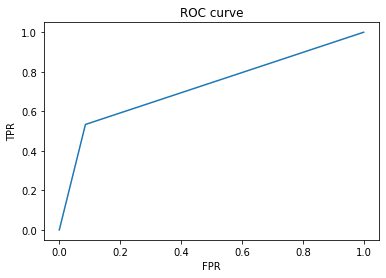

AUC Score = 72.38 %
Model: XGBoost
------------------------------------------------------------



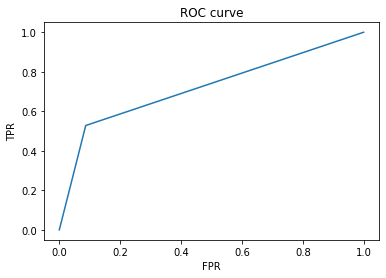

AUC Score = 72.06 %
Model: Gradient Boosting
------------------------------------------------------------



In [16]:
#fitting vanilla models on X & y
def vanilla_model(predictors,target, model):
    x_train,x_val,y_train,y_val = train_test_split(predictors,target,test_size=0.2,random_state=42)
    model.fit(x_train, y_train)
    y_scores = model.predict(x_val)
    auc = roc_auc_score(y_val, y_scores)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_scores)

    plt.plot(false_positive_rate, true_positive_rate)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC curve')
    plt.show()
    return auc

models = {'Logistic Regression':LogisticRegression,'Decision Tree':DecisionTreeClassifier,'Random Forest': RandomForestClassifier,'XGBoost':XGBClassifier,'Gradient Boosting':GradientBoostingClassifier}

for i in models.items():
    model = i[1]()
    auc = vanilla_model(X, y, model)
    print('AUC Score = %.2f' %(auc*100) +' %\nModel: '+str(i[0]))
    print('---'*20)
    print()

These are the models that performed well on validation data (in decreasing order):

1. Logistic Regression
2. Gradient Boosting
3. XGBoost
4. Random Forest
5. Decision Tree   



#### c. Improving ML model

Since logistic regression is the one that performed well so we are choosing it to apply hyperparameter tuning on it using grid search cross validation.

In [17]:
!pip install imblearn
from imblearn.over_sampling import SMOTE

On Validation Data
ROC_AUC_SCORE is  0.76923564557283
              precision    recall  f1-score   support

           0       0.91      0.73      0.81      1539
           1       0.53      0.80      0.64       574

    accuracy                           0.75      2113
   macro avg       0.72      0.77      0.73      2113
weighted avg       0.81      0.75      0.77      2113



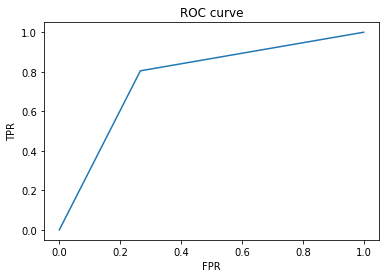

In [18]:
#applying gridsearch cv on logistic regression 
x_train,x_val,y_train,y_val = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(kind='regular')
X_sm, y_sm =  smote.fit_sample(x_train, y_train)
    
log_reg = LogisticRegression()
    
param_grid = {'C' : np.logspace(-5, 8, 15)}
grid_search = GridSearchCV(log_reg, param_grid=param_grid)
    
grid_search.fit(X_sm, y_sm)
y_pred = grid_search.predict(x_val)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, y_pred)
print('On Validation Data')
print('ROC_AUC_SCORE is ',roc_auc_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
plt.clf()
plt.plot(false_positive_rate, true_positive_rate)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

As expected, the grid search CV spilled out the best suited hyperarameter, which is evident on ROC score. So we are selecting it to be the model for the flask app.

#### d. Saving ML model

In [19]:
#creating a pickle file of best suited model, which is logistic regression after performing grid search 
#i.e. 'grid_search_log_reg'

import pickle
pickle.dump(grid_search, open('model.pkl','wb'))

---